QUE AVEC DES DONNEES 

# PINNs Advection Equation

This notebook solves the advection-diffusion equation using a physics-informed neural network (PINN). The equation is given by:

\begin{cases}
\partial_t u + a \partial_x u = 0 \\
u(t=0, x) = u_0(x, \mu)
\end{cases}

where $u$ is the dependent variable, $t$ is time, $x$ is space, and $a$ is the diffusion coefficient (velocity) The initial condition is given by:

\begin{equation}
u_0(x) = \exp(-(x-0.5)^2/0.1^2)
\end{equation}

The exact solution is given by:
`
\begin{equation}
u(x,t) = u_0(x-a*t)
\end{equation}



## Analysis:

### Neural Network
A neural network is a function that maps an input $X$ to an output $Y$ by performing successive linear and nonlinear transformations. The linear transformations are represented by a set of weights $W$ and biases $b$ and the nonlinear transformations are represented by activation functions $\sigma$. The output of a neural network is given by:

$$\overline{u_\theta}(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

We will train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset. 

### Physics Informed Neural Network = NN + PDE

We can use a neural network to approximate any function (Universal APproximation Theorem). In our case, we want to approximate the solution of a PDE. We can do this by minimizing the error of the PDE in a certain number of points inside our domain.

$$\overline{u_\theta}\approx u(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial \overline{u_\theta}}{\partial t},\frac{\partial \overline{u_\theta}}{\partial x}$.

We assume then: $$\overline{u_\theta}(x,t)\approx u(x,t,\theta)$$ 

Then:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a \frac{\partial \overline{u_\theta}}{\partial x}\right) \approx \left(\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x}\right) =0$$

And:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a\frac{\partial \overline{u_\theta} }{\partial x}\right) \approx 0$$

We should also define the boundary conditions both in space and time as it follows:

boundary conditions in space:

$$bc_{space}(x)=x*(x-1)$$

boundary conditions in time:
$$bc_{time}(t)=t$$

Now we can define this function as $u_\theta$:

$${u_\theta}(x,t)= u_{0}(x)+ bc_{time}(t) * bc_{space}(x) * \overline{u_\theta}(x,t)$$ 

If $u_\theta \rightarrow 0$ then our $\overline{u_\theta}$ would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_{coll}$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $u_\theta$:

$$MSE_{u_\theta}=\frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i)|^2$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u_{exact}}=\frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|y(t_{u_{exact}}^i,x_{u_{exact}}^i)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u_{exact}}+MSE_{u_\theta}$$

We are looking to minimize:
$$
\Theta* = argmin_\Theta \left\{ \frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i)|^2 + \frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|y(t_{u_{exact}}^i,x_{u_{exact}}^i)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i)|^2 \right\}
$$

where $u_\theta$ is the PDE and $u$ is the exact solution.

In [49]:
import os


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import L1Loss
from torch.optim import lr_scheduler
import torch.nn.functional as F

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

torch loaded; device is cpu


## Neural Network 

In [50]:
class Net(nn.DataParallel): 
    """Defines the neural network model"""
    def __init__(self):
        
        super(Net, self).__init__(nn.Module)
        self.hidden_layer1 = nn.Linear(2, 20).double()  #double pour 
        self.hidden_layer2 = nn.Linear(20, 60).double()
        self.hidden_layer3 = nn.Linear(60, 60).double()
        self.hidden_layer4 = nn.Linear(60, 60).double()
        self.hidden_layer5 = nn.Linear(60, 20).double()
        self.output_layer = nn.Linear(20, 1).double()

    """Defines the sequence of operations that are applied to the input tensors to produce the output of the neural network"""
    def forward(self, x, t):
    
        inputs = torch.cat([x,t], axis=1)
        layer1_out = F.elu(self.hidden_layer1(inputs))
        layer2_out = F.elu(self.hidden_layer2(layer1_out))
        layer3_out = F.elu(self.hidden_layer3(layer2_out))
        layer4_out = F.elu(self.hidden_layer4(layer3_out))
        layer5_out = F.elu(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

"""To impose hard boundary constraints"""
def network_BC(t): #t to define u_theta
    return t 

## Parameters

In [51]:
class Parameters:
   def __init__(self, tf, file_name):
        self.xmin = 0.
        self.xmax = 1.
        self.tmin = 0.
        self.tmax = tf
        self.a = 1.
        self.learning_rate = 1e-4 #1e-3
        self.file_name = file_name
      #   self.minA = 0.5 #ajustar para un mejor aprendizaje
      #   self.maxA = 0.8
        self.A = 0.7 #ajustar para un mejor aprendizaje
        self.B = 0.3 #on fixe B
     
   def u0(self, x):
      return torch.where((x >= 0.30) & (x <= 0.60), self.A, self.B).double()

## PINN

In [52]:
class Network:

    def __init__(self,param: Parameters):

        """Initializes the neural network model"""
        self.parameters = param 
        self.x_min, self.x_max = param.xmin, param.xmax
        self.t_min, self.t_max = param.tmin, param.tmax
        self.learning_rate = param.learning_rate
        self.u0 = param.u0
        self.tf = param.tmax
        self.a = param.a
        self.file_name = param.file_name
        self.A = param.A
        self.B = param.B

        #To save the model
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #returns the current working directory
        self.load(self.file_name)
        
    """This method calls the neural network model"""
    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = nn.DataParallel(Net()).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate) #optimization algorithm
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.01)
   
    def load(self, file_name):
        self.loss_history = []
        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t):

        u = self.u0(x) + network_BC(t) * self(x, t)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] # it enables the creation of a computational graph for the gradients. A computational graph is a data structure that represents the operations performed on tensors and their dependencies, which allows for automatic differentiation and backpropagation.
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] 
        
        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t): # x tensor pour lequel on calcule la solution, t float, u0 float qu'on converti en tensor 
        ones = torch.ones(x.shape, dtype=torch.double, device=device)
        pt_t = t * ones
        pred = self.u0(x) + network_BC(pt_t) * self(x, pt_t)

        return pred

    #Pour l'instant c'est pas utilisé
    """This method predicts the value of u for a given input x and a mesh object"""
    def predict_u(self, x, t, mesh): # x float t float mesh object

        #We need to reshape the input x to be a column vector
        reshaped_x = x.reshape((x.size, 1))
        pt_x = Variable(torch.from_numpy(reshaped_x).double(), requires_grad=True).to(device)
        reshaped_t = t.reshape((x.size, 1))
        pt_t = Variable(torch.from_numpy(reshaped_t).double(), requires_grad=False).to(device)

        u_pred = self.u0(pt_x) + network_BC(pt_t) * self(pt_x, pt_t)

        return u_pred.detach().cpu().numpy().reshape(x.shape)
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)
        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)
        
        self.u_data_exact = Network.u_exact(self.x_data, self.t_data, self.a ,self.x_max, self.u0) # la solution exacte evaluée dans (xi,ti)
        self.zeros1 = torch.zeros(shape, dtype=torch.double, device=device) 
        
    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        #These variables will be used to evaluate the PDE at the collocation points.
        #collocation points are additional points where the PDE will be evaluated to ensure that the neural network solution satisfies the PDE
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) #This will be used as a target for the PDE constraints.

    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, epochs, n_collocation, n_data):

        # mse_cost_function = torch.nn.MSELoss()
        #mae_cost_function = L1Loss() mae 
        smooth_l1_loss = torch.nn.MSELoss()
        #nn.SmoothL1Loss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):

            self.optimizer.zero_grad()

            self.loss = 0


            if n_collocation > 0:
                # Loss based on PDE constraints
        
                self.make_collocation(n_collocation)
                f_out = self.pde(self.x_collocation, self.t_collocation)

                # Define the weight factor lambda
                # divergence_u = torch.autograd.grad(f_out.sum(), self.x_collocation, create_graph=True)[0]
                # lambda_factor = 1.0 / ((torch.abs(divergence_u) - divergence_u) + 1.0)
                lambda_factor = 1e-2
                #mse_f = mse_cost_function(f_out, self.zeros)
                mae_f = smooth_l1_loss(lambda_factor * f_out, self.zeros)
                # mae_f =  smooth_l1_loss(f_out, self.zeros)
               
                self.loss += mae_f
            

            if n_data > 0:
                # Loss based on data fitting (on apprend que avec des donées)
                self.make_data(n_data)
                u_pred = self.predict_u_from_torch(self.x_data, self.t_data) #reseau evaluée dans (xi,ti)
                #on essaie de minimizer la différence entre la solution exacte et la solution du réseau calculées en (xi,ti)
                #mse_data = mse_cost_function(u_pred, self.u_data_exact) 
                mae_data = smooth_l1_loss(u_pred, self.u_data_exact)
                
                self.loss += mae_data

            """Losses based on a combination of PDE constraints in the interior and boundary conditions""" 

            """data points"""
            xmin_tensor = torch.full(self.x_data.size(), self.x_min, dtype=torch.double, device=device, requires_grad=True)
            xmax_tensor = torch.full(self.x_data.size(), self.x_max, dtype=torch.double, device=device, requires_grad=True)
            tmin_tensor = torch.full(self.t_data.size(), self.t_min, dtype=torch.double, device=device, requires_grad=True)
            tmax_tensor = torch.full(self.t_data.size(), self.t_max, dtype=torch.double, device=device, requires_grad=True)
          
            """To enforce the boundary conditions, we evaluate the neural network solution at the boundary points and compare it to the boundary values."""
            #boundary (periodicity) in x
            f_boundary1 = self.predict_u_from_torch(xmin_tensor, self.t_data)
            f_boundary2 = self.predict_u_from_torch(xmax_tensor, self.t_data)
            f_boundaryx= torch.abs(f_boundary1 - f_boundary2)
            mae_f_boundaryx =  smooth_l1_loss(f_boundaryx, self.zeros1)

            #boundary (periodicity) in t
            f_boundary3 = self.predict_u_from_torch(self.x_data, tmin_tensor)
            f_boundary4 = self.predict_u_from_torch(self.x_data, tmax_tensor)
            f_boundaryt= torch.abs(f_boundary3 - f_boundary4)
            mae_f_boundaryt =  smooth_l1_loss(f_boundaryt, self.zeros1)

            #Initial condition
            f_initial = self.predict_u_from_torch(self.x_data, self.t_min)
            f_initial_real= self.u0(self.x_data)
            f_initiale = torch.abs(f_initial - f_initial_real)
            mae_f_initial = smooth_l1_loss(f_initiale, self.zeros1)

            self.loss += mae_f_initial + mae_f_boundaryx + mae_f_boundaryt  

            # On fait la backpropagation et on met à jour les poids
            self.loss.backward() # This is for computing gradients using backward propagation
            self.optimizer.step() #This is equivalent to the update step in the gradient descent algorithm
            self.scheduler.step()

            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)

        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, xmax, u0, device=device):
        return u0((x - a * t) % xmax)
    
    
    def plot(self, t):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 10000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]
    
            u_pred = self.predict_u_from_torch(x, t)
            u_exact = Network.u_exact(x, t, self.a, self.x_max, self.u0)

            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="Exact solution")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="Prediction (NN)")
            ax[1].set_title("Prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("Prediction error")

            print("Error ", torch.abs(u_pred - u_exact).mean().detach().cpu().item())
   

## Implementation of the code

In [53]:
# if __name__ == "__main__":

#     file_name = "test_new24.pth"
#     params= Parameters(tf=1., file_name=file_name)
#     network = Network(params)

#     if device.type == "cpu":
#         #network.train(epochs=500, n_collocation=0, n_data=100000) #sans PDE constraints juste avec les données (supervisé)
#         network.train(epochs=100, n_collocation=1000, n_data=900) #sans data fitting (non supervisé)

#     else:
#         network.train(epochs=500, n_collocation=20000, n_data=2500)

In [54]:
epocs = 20000
n_collocation = 0 #cela ne chnage rien si j'aoute des points de collocation
n_data = 50000
filename = "solu54"

params = Parameters(1., file_name=filename)
network = Network(params)
network.train(epocs, n_collocation, n_data)

network was not loaded from file: training needed
epoch     0: current loss = 1.44e-01
epoch     0: best loss = 1.44e-01
epoch     1: best loss = 1.40e-01


epoch     2: best loss = 1.39e-01
epoch     3: best loss = 1.36e-01
epoch     4: best loss = 1.34e-01
epoch     5: best loss = 1.31e-01
epoch     6: best loss = 1.28e-01
epoch     7: best loss = 1.28e-01
epoch     8: best loss = 1.24e-01
epoch     9: best loss = 1.22e-01
epoch    10: best loss = 1.20e-01
epoch    11: best loss = 1.19e-01
epoch    12: best loss = 1.17e-01
epoch    13: best loss = 1.15e-01
epoch    14: best loss = 1.13e-01
epoch    15: best loss = 1.11e-01
epoch    16: best loss = 1.08e-01
epoch    17: best loss = 1.08e-01
epoch    18: best loss = 1.05e-01
epoch    19: best loss = 1.04e-01
epoch    20: best loss = 1.02e-01
epoch    21: best loss = 1.00e-01
epoch    22: best loss = 9.80e-02
epoch    23: best loss = 9.72e-02
epoch    24: best loss = 9.54e-02
epoch    25: best loss = 9.44e-02
epoch    26: best loss = 9.23e-02
epoch    27: best loss = 9.21e-02
epoch    28: best loss = 8.97e-02
epoch    29: best loss = 8.87e-02
epoch    30: best loss = 8.72e-02
epoch    31: b

Error  0.0
Error  0.2050952951789878
Error  0.2447249425152866
Error  0.202657452063817
Error  0.002906608112084836


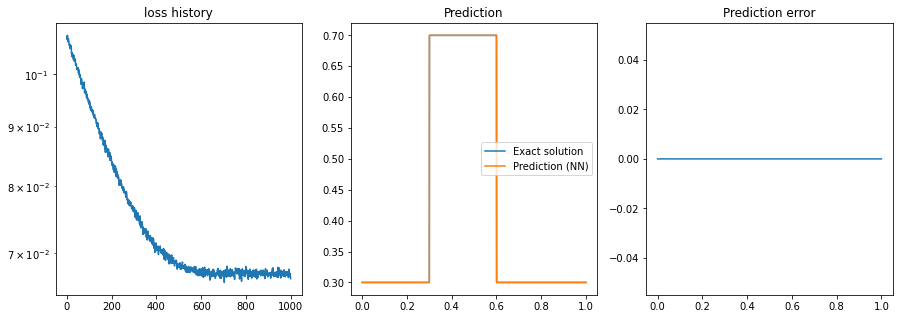

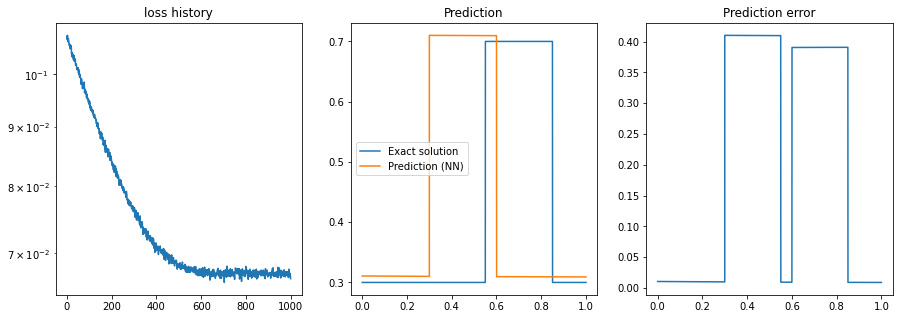

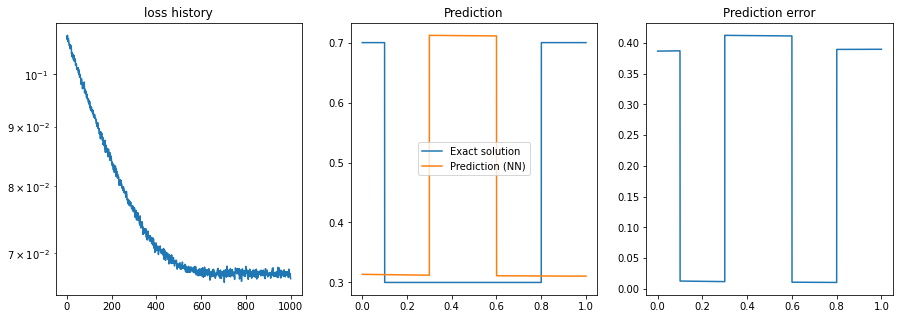

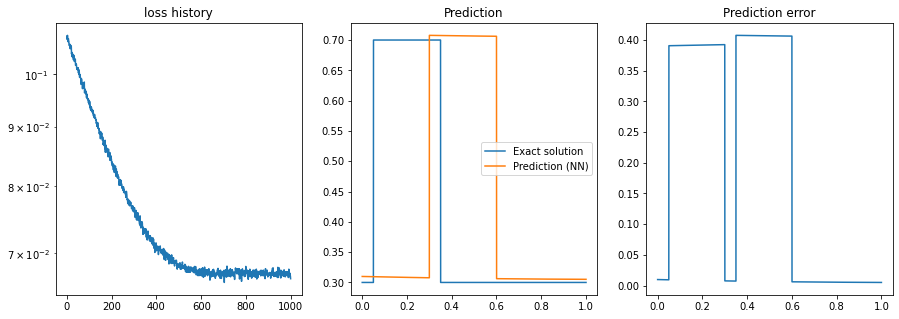

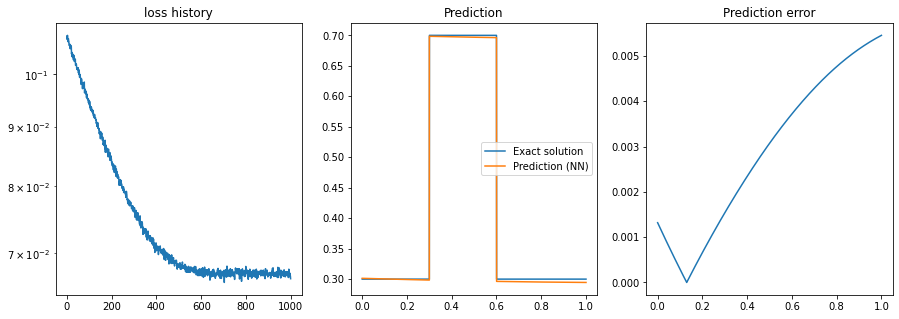

In [ ]:
temps = [0., 0.25, 0.5, 0.75, 1.]
for t in temps:
    network.plot(t)


In [ ]:
"""A function that will create the mesh"""

def mesh (xmin, xmax, tmin, tmax, nx, nt):
    x = np.linspace(xmin, xmax, nx, endpoint=True)
    t = np.linspace(tmin, tmax, nt, endpoint=True)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    return x, t, dx, dt

class SemiLagrangianSolver:

    def __init__(self, xmin, xmax, tmin, tmax, nx, nt, a, order,network,A,B):
        
        self.xmesh, self.tmesh, self.delta_x, self.delta_t = mesh(xmin, xmax, tmin, tmax, nx, nt)

        self.xmax = xmax
        self.xmin = xmin
        self.tmax = tmax
        self.a = a #velocity
        self.nt=nt
        self.nx=nx
        self.u = np.zeros((nt, nx))
        self.u_deep = np.zeros((nt, nx))
        self.order=order
        self.network = network
        self.A = A
        self.B = B
    
    """Function that defines the u(t=0, x) initial condition"""

    def u_0(self, x, A):
        return np.where((x >= 0.25) & (x <= 0.75), A, self.B)
    
    def explicit_solution(self, x, t, A):
        shifted_x = (x - self.a * t) % self.xmax  # Wrap the shifted coordinates to the domain boundaries
        return np.where((shifted_x >= 0.25) & (shifted_x <= 0.75), A, self.B)


    """Function that calculates the closest points to the point x_star (phantom point) 
       based on the x_i point and returns the indexes and the x_star point"""

    def find_closest(self, index):
        # We first calculate the x_star point
        x_i = self.xmesh[index]
        # We take into account the periodicity of the domain
        x_star = (x_i - self.a * self.delta_t) % self.xmax
    
        # We calculate the k index so that x_star is in between x_k and x_{k+1}
        k = int(x_star / self.delta_x)
        #We calculate the other indexes based on k and the order
        indexes = np.zeros(self.order+1, dtype=int)
        indexes = np.arange(k - (self.order//2), k + (self.order//2) + 2)
        indexes = np.mod(indexes, self.nx)
        return indexes, x_star


    """Function that calculates the Lagrange basis polynomial Li at x_star"""
    
    def Li(self, x_star, x_closest, i):
        result = 1.0
        for j in range(len(x_closest)):
            if j != i:
                result *= (x_star - x_closest[j]) / (x_closest[i] - x_closest[j])
        return result

    """Function that calculates the numerical solution of the Transport equation 
       using de Lagrange interpolation operator"""
 
    def solver(self): #We calculate for t+1 at index index i the mesh at that time 

        self.u[0,:] = self.u_0(self.xmesh, self.A)
        
        #We calculate the solution for each time step and each x_i point
        for t in range(self.nt-1):
            for i in range(self.nx):
                # We calculate the closest points to x_star
                closest_indexes, x_star = self.find_closest(i)
                # We retrieve the closest points in our mesh
                x_closest = self.xmesh[closest_indexes]
                # We retrieve the solution at the closest pointsat the time t
                u_closest = self.u[t, closest_indexes]
                li = np.zeros(self.order+1)
                for j in range(self.order+1):
                    li[j] = self.Li(x_star, x_closest, j)

                u_sol = np.sum(u_closest*li)

                self.u[t+1,i] = u_sol   

        return self.u
    

    """u_thetai function""" 
    def u_theta(self, x, t):
        pred= self.network.predict_u_from_torch(x, t)
        return pred.detach().cpu().numpy() 

    """Function that calculates using the Deep Lagrange interpolation the numerical solution of the transport equation"""

    def solver_deep(self):
        self.u_deep[0,:] = self.u_0(self.xmesh, self.A)

        for t in range(self.nt-1):
            for i in range(self.nx):
                #print("t=", t, "i=", i)
                closest_indexes, x_star = self.find_closest(i) #We get the closest indexes 
        
                x_closest = self.xmesh[closest_indexes] #We get the values of the mesh at those closest indexes
                x_closest_tensor = torch.tensor(x_closest.reshape(-1, 1), dtype=torch.float32).clone().detach() #we convert the array into a tensor
            
                u_closest = self.u_deep[t][closest_indexes] #We get the values of the solution at those closest indexes at time t
                u_theta_tensor = self.u_theta(x_closest_tensor, self.tmesh[t]) #We calcualte 

                #We convert the tensor into an array
                u_theta_i=[]
                for k in range(len(u_theta_tensor)):
                    u_theta_i.append(u_theta_tensor[k].item())

                u_closest_theta = u_closest / u_theta_i
                #print("u_closest_theta=", u_closest_theta)
                li = np.zeros(self.order+1)
                for j in range(self.order+1):
        
                    li[j] = self.Li(x_star, x_closest, j)
            
                    x_star_tensor = torch.tensor(x_star.reshape(-1, 1), dtype=torch.float32).clone().detach() #We convert x_star into a tensor 
                    u_theta_tensor = self.u_theta(x_star_tensor, self.tmesh[t]) #We
                    u_theta = u_theta_tensor.item() #We get the floar out of the the tensor
                    li[j] *= u_theta
                
                u_sol = np.sum(u_closest_theta * li)
                #print("u_exact", self.explicit_solution(x_star, self.tmesh[t+1]))
                #print("u_sol=", u_sol)
                self.u_deep[t+1][i] = u_sol

        return self.u_deep



    """Function that will show the plot of the solution at a given time t"""
  
    def plot_solution(self,t):
        plt.plot(self.xmesh, self.u[t,:], label = 'numerical solution')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t],self.A), label = 'exact solution')
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution")
        plt.legend()
        plt.show()
    

    """Function that will show the plot of the solution using deep interpolation at a given time t"""
    def plot_solution_deep(self,t):
        plt.plot(self.xmesh, self.u_deep[t,:], label = 'u deep with PINNs')
        #print("deep",self.u_deep[t,:])
        #xmesh_tensor = torch.tensor(self.xmesh.reshape(-1, 1), dtype=torch.float32).clone().detach()
        #plt.plot(self.xmesh, self.u_theta(xmesh_tensor, self.tmesh[t]), label = 'sol donné par le reseau')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t],self.A), label = 'exact solution')
        #print("exact",self.explicit_solution(self.xmesh, self.tmesh[t]))
        plt.plot(self.xmesh, self.u[t,:], label = 'u')
        #print("u",self.u[t,:])
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution deep")
        plt.legend()
        plt.show()

        
    """ Function that will calculate the error of the numeral solution compared to the analytical solution at a given time t"""
    def error_solution(self, t):

        if t > 0:
            return np.sum(np.linalg.norm(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t],self.A), ord=2))
        else:
            return 0
     
    """Function that will calculate the error in infinity norm for both solutions"""
    def error_inf_norm(self):
        diff = 0
        for t in range(1,self.nt):
            diff = np.abs(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t],self.A))
            norm = np.max(diff)
        return norm

    def error_inf_norm_deep(self):
        diff = 0
        for t in range(1,self.nt):
            diff = np.abs(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t],self.A))
            norm = np.max(diff)
        return norm
    
    """Function that will calculate the error in L2 norm for both solutions"""
    # def error_L2_norm_deep(self ):
    #     norm = 0
    #     for t in range(self.nt):
    #         diff = self.explicit_solution(self.xmesh, self.tmesh[t])-self.u_deep[t,:]
    #         for j in range(self.nx):
    #             norm += (diff[j-1]**2 + diff[j]**2 )* self.delta_x / 2
    def error_L2_norm_deep(self, t):
        norm = 0
        diff = self.explicit_solution(self.xmesh, self.tmesh[t],self.A) - self.u_deep[t, :]
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm

    # def error_L2_norm(self):
    #     norm = 0
    #     for t in range(self.nt):
    #         diff = self.explicit_solution(self.xmesh, self.tmesh[t]) - self.u[t, :]
    #         for j in range(self.nx):
    #             norm += (diff[j-1] ** 2 + diff[j] ** 2) * self.delta_x / 2
    #     return norm
    def error_L2_norm(self, t):
        norm = 0
        diff = self.explicit_solution(self.xmesh, self.tmesh[t],self.A) - self.u[t, :]
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm


    """ Function that will calculate the error of the numeral deep solution compared to the analytical solution at a given time t"""
    def error_solution_deep(self, t):
        if t > 0:
            return np.sum(np.linalg.norm(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t],self.A), ord=2))
        else:
            return 0
        
    # def NN_error(self):
    #     norm = 0
    #     for t in range(self.nt):
    #         u_theta_tensor = self.u_theta(self.xmesh, self.tmesh[t])
    #         u_theta_array = u_theta_tensor.detach().cpu().numpy()
    #         diff = (u_theta_array - self.explicit_solution(self.xmesh, self.tmesh[t])).mean()
    #         norm += np.linalg.norm(diff, ord=2)
    #     return norm
    def NN_error(self, t):
        norm = 0
        u_theta=[]

        xmesh_tensor = torch.tensor(self.xmesh.reshape(-1, 1), dtype=torch.float32).clone().detach()
        u_theta_tensor = self.u_theta(xmesh_tensor, self.tmesh[t])
    
        for k in range(len(u_theta_tensor)):
            u_theta.append(u_theta_tensor[k].item())
        u_theta = np.array(u_theta)
        diff = (u_theta - self.explicit_solution(self.xmesh, self.tmesh[t],self.A))
        
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm  




In [ ]:
"""We first define the values of the parameters of the solver """
xmin = 0.
xmax = 1.
tmin = 0.   
tmax = 1.
nx = 20
nt = 100 
a=1
A= 0.7
B= 0.3
         
solver = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3, network, A, B)
X = solver.xmesh
T = solver.tmesh

"""We verify the CFL condition"""

print("cfl solver" , a*solver.delta_t/solver.delta_x)

"""Solutions of the problem"""
u_semilag = solver.solver()
u_semilag_deep = solver.solver_deep()

"""Exact solution"""
u_exact = np.zeros((solver.nt, solver.nx))
for i in range(solver.nt):
    for j in range(solver.nx):
        u_exact[i,j] = solver.explicit_solution(X[j], T[i], solver.A)

cfl solver 0.19191919191919193


In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

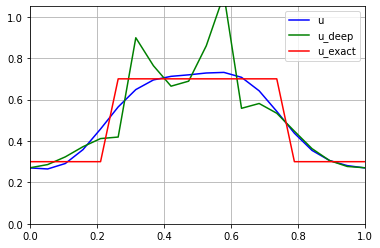

In [ ]:
fig, ax = plt.subplots()
line_u_semilag, = ax.plot([], color='blue', label='u')
line_u_semilag_deep, = ax.plot([], color='green', label='u_deep')
line_exact, = ax.plot([], color='red', label='u_exact')
ax.grid()
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)
ax.legend()

def animate(frame_num):
    line_u_semilag.set_data(X, u_semilag[frame_num,:])
    line_u_semilag_deep.set_data(X, u_semilag_deep[frame_num,:])
    line_exact.set_data(X, u_exact[frame_num,:])
    return line_u_semilag, line_u_semilag_deep, line_exact

anim_bis = FuncAnimation(fig, animate, frames=solver.nt, interval=120, blit=True)
anim_bis.save("animation" + str(solver.A) + ".gif", writer='pillow')